<a href="https://colab.research.google.com/github/Agnes-FD/Agnes-FD/blob/main/modelv22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import datasets
import matplotlib.image as mpimg
import os

In [2]:
%matplotlib inline

In [3]:
import keras
from keras.layers import Conv2D, MaxPooling2D, Dense, Input, Flatten, Dropout, UpSampling2D, GlobalAveragePooling2D
from keras.models import Model
from keras.optimizers import Adam, SGD
import matplotlib.pyplot as plt
from keras.utils import np_utils
from keras.datasets import cifar10
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from IPython.display import Image, display
import random, os

In [4]:
#Make sure you're using GPU
!nvidia-smi

Wed Jun 16 04:14:23 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
from google.colab import drive
drive.mount ('/content/drive')

Mounted at /content/drive


In [6]:
cd '/content/drive/MyDrive/data'

/content/drive/MyDrive/data


In [7]:
path = '/content/drive/MyDrive/data'
# Membuat Label pada gambar berdasarkan klasifikasi
file_name = []
tag = []
full_path = []
for path, subdirs, files in os.walk(path):
  for name in files:
    full_path.append(os.path.join(path, name))
    tag.append(path.split('/')[-1])
    file_name.append(name)

In [9]:
# Membuat dataframe berdasarkan hasil klasifikasi data yang sudah diberi label

df = pd.DataFrame({"path":full_path, "file_name": file_name, "tag":tag})
df.groupby(['tag']).size()

tag
with_mask       3725
without_mask    3828
dtype: int64

In [10]:
# Membagi dataset menjadi dua bagian (train dan test)
from sklearn.model_selection import train_test_split

x = df['path']
y = df['tag']

x_train, x_test, y_train, y_test = train_test_split(
    x,y, test_size= 0.20, random_state=300)

In [11]:
# menyatukan kedalam masing-masing dataframe
df_test = pd.DataFrame({
    'path' : x_test,
    'tag' : y_test,
    'set' : 'test'
})

df_train = pd.DataFrame({
    'path' : x_train,
    'tag' : y_train,
    'set' : 'train'
})

In [12]:
print('train size', len(df_train))
print('test size', len(df_test))

train size 6042
test size 1511


In [14]:
# melihat masing-masing dataset apakah sudah sesuai atau belum
df_all = df_train.append([df_test]).reset_index(drop=1)

print('===================================================== \n')
print(df_all.groupby(['set','tag']).size(),'\n')

print('===================================================== \n')

df_all.sample(4)


set    tag         
test   with_mask        739
       without_mask     772
train  with_mask       2986
       without_mask    3056
dtype: int64 




,path,tag,set
1723,/content/drive/MyDrive/data/without_mask/witho...,without_mask,train
4405,/content/drive/MyDrive/data/with_mask/with_mas...,with_mask,train
4139,/content/drive/MyDrive/data/without_mask/witho...,without_mask,train
6779,/content/drive/MyDrive/data/without_mask/witho...,without_mask,test


In [15]:
# Memindahkan dataset
import shutil
from tqdm.notebook import tqdm as tq

datasource_path = '/content/drive/MyDrive/data'
dataset_path = '/content/drive/MyDrive/dataset'

for index, row in tq(df_all.iterrows()):
  file_path = row['path']

  if os.path.exists(file_path) == False:
    file_path = os.path.join(datasource_path, row['tag'], row['image'].split('.')[0])

  if os.path.exists(os.path.join(dataset_path, row['set'], row['tag'])) == False:
    os.makedirs(os.path.join(dataset_path, row['set'], row['tag']))
  
  destination_file_name = file_path.split('/')[-1]
  file_dest = os.path.join(dataset_path, row['set'], row['tag'], destination_file_name)

  if os.path.exists(file_dest) == False:
    shutil.copy2(file_path, file_dest)

In [16]:
# Define Directory
base_dir = '/content/drive/MyDrive/dataset'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

In [17]:
os.listdir(train_dir)

['with_mask', 'without_mask']

In [18]:
os.listdir(test_dir)

['with_mask', 'without_mask']

In [19]:
!ls '/content/drive/MyDrive/dataset/test/'

with_mask  without_mask


In [20]:
test_imgs_count = sum([len(files) for r, d, files in os.walk("/content/drive/MyDrive/dataset/test/")])
test_imgs_count

1511

In [21]:
train_imgs_count = sum([len(files) for r, d, files in os.walk("/content/drive/MyDrive/dataset/train/")])
train_imgs_count

6042

In [22]:
batch_size_train = 71
batch_size_test = 1

In [32]:
def display20randomimages(t):
  fig=plt.figure(figsize=(8, 8))
  columns = 4
  rows = 5
  for i in range(1, columns*rows +1):
    c = "/" + str(random.choice(['with_mask/'])) + "/"
    random_filename = random.choice([
        x for x in os.listdir(t + c)
        if os.path.isfile(os.path.join(t+c, x))
    ])
    img = mpimg.imread(t+c+random_filename)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
  plt.show()

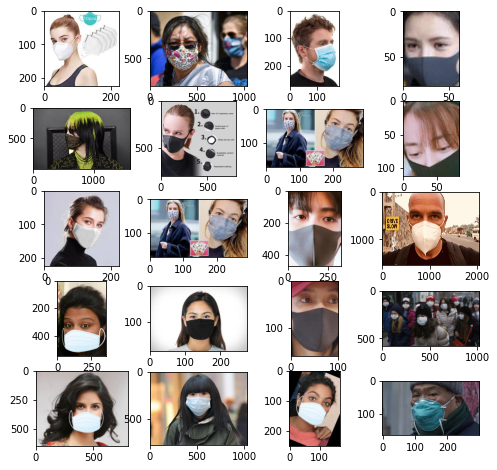

In [33]:
display20randomimages('/content/drive/MyDrive/data')

In [34]:
def display20randomimages(t):
  fig=plt.figure(figsize=(8, 8))
  columns = 4
  rows = 5
  for i in range(1, columns*rows +1):
    c = "/" + str(random.choice(['without_mask/'])) + "/"
    random_filename = random.choice([
        x for x in os.listdir(t + c)
        if os.path.isfile(os.path.join(t+c, x))
    ])
    img = mpimg.imread(t+c+random_filename)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
  plt.show()

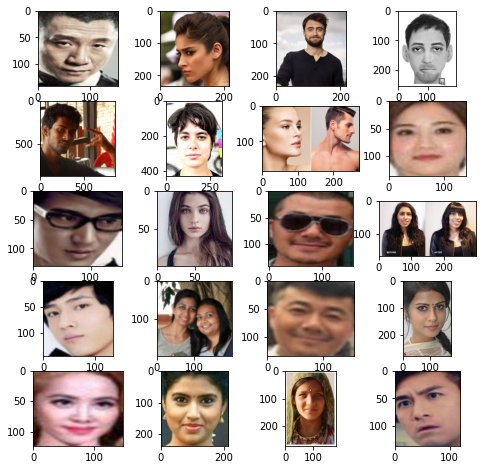

In [35]:
display20randomimages('/content/drive/MyDrive/data')